In [12]:
import os
import re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from typing import Dict, Tuple, Union

warnings.filterwarnings("ignore")

# For better visualizations
sns.set_theme(style="ticks", palette="muted", color_codes=True)

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

from wordcloud import WordCloud

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
dataset="datasets/reddit_posts_with_topics_keywords_sentiments.csv"

df = pd.read_csv(dataset)
df.head()

,post_id,title,timestamp,body,body_type,topic_name,cleaned_text,keywords,sentiment_label,sentiment_score
0,1b0m6c1,r/CasualConversation is looking for new modera...,2024-02-26 16:48:14,"Hello everyone,It's that time again, [we're lo...",post,22_subs_subreddits_trolls_subreddit,hello everyone time look new mod join team doc...,"modmail courteous professional,grow strict quo...",positive,0.592145
1,1b5h6x7,Deleting social media was one of the best thin...,2024-03-03 13:29:12,I know that technically reddit is a social med...,post,1_fb_deleted_instagram_facebook,know technically reddit social medium not nega...,"consider delete social,instagram tiktok,health...",positive,0.817773
2,1b5lu9j,Lonlieness is not about gender! My Opinion.,2024-03-03 16:56:09,Okay so I just wanted to get this off of my mi...,post,359_loneliness_lonely_epidemic_intiate,okay want get mind keep see people post man lo...,"man loneliness epidemic,understand gender thin...",negative,0.736416
3,1b5jo0m,Have you gave up any hobbies?,2024-03-03 15:23:08,I used to be a doll collector. Then when I was...,post,-1_breakfast_cream_listening_bus,use doll collector tell weird old donate every...,"use doll collector,throw away hobby,day happy ...",negative,0.638780
4,1b5c8ah,Is it me or has the world just stopped moving ...,2024-03-03 08:24:06,"This is strange, but I feel like:1) I don’t re...",post,-1_breakfast_cream_listening_bus,strange feel like not remember anything happen...,"good year covid,like remember happen,people tr...",negative,0.756849


In [3]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'  # Default to noun

def lemmatize_string(s):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Split the string into words
    words = s.split("_")

    # Get the POS tag for each word
    pos_tags = nltk.pos_tag(words)

    # Lemmatize each word based on its POS tag
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in pos_tags]

    # lemmatized_words = [lemmatizer.lemmatize(w, pos='v') for w in words]

    # Remove duplicates while preserving order
    lemmatized_words = list(dict.fromkeys(lemmatized_words))

    # Join the words back into a string
    result = "_".join(lemmatized_words)

    return result

In [4]:
# Apply lemmatize function to topics name and then return as a dict
lemmatized_topics_dict = (
    df.loc[:, 'topic_name']
    .drop_duplicates(ignore_index=True)
    .to_frame('topics')
    .assign(topic_num=lambda x: x['topics'].str.extract(r'^(-?\d+)_', expand=False),
            topic_name=lambda x: x['topics'].str.extract(r'^-?\d+_(.+)$', expand=False))
    .assign(lema_topic_name=lambda x: x['topic_num'] + "_"+ x['topic_name'].apply(lemmatize_string))
    .set_index("topics")
    .loc[:, 'lema_topic_name']
    .to_dict()
)

# Showing first 3 key-pairs only
dict(list(lemmatized_topics_dict.items())[:3])

{'22_subs_subreddits_trolls_subreddit': '22_subs_subreddits_troll_subreddit',
 '1_fb_deleted_instagram_facebook': '1_fb_delete_instagram_facebook',
 '359_loneliness_lonely_epidemic_intiate': '359_loneliness_lonely_epidemic_intiate'}

In [5]:
df = (
    df.assign(topics=lambda x: x['topic_name'].map(lemmatized_topics_dict))
    .drop('topic_name', axis=1)
)

df.head()

,post_id,title,timestamp,body,body_type,cleaned_text,keywords,sentiment_label,sentiment_score,topics
0,1b0m6c1,r/CasualConversation is looking for new modera...,2024-02-26 16:48:14,"Hello everyone,It's that time again, [we're lo...",post,hello everyone time look new mod join team doc...,"modmail courteous professional,grow strict quo...",positive,0.592145,22_subs_subreddits_troll_subreddit
1,1b5h6x7,Deleting social media was one of the best thin...,2024-03-03 13:29:12,I know that technically reddit is a social med...,post,know technically reddit social medium not nega...,"consider delete social,instagram tiktok,health...",positive,0.817773,1_fb_delete_instagram_facebook
2,1b5lu9j,Lonlieness is not about gender! My Opinion.,2024-03-03 16:56:09,Okay so I just wanted to get this off of my mi...,post,okay want get mind keep see people post man lo...,"man loneliness epidemic,understand gender thin...",negative,0.736416,359_loneliness_lonely_epidemic_intiate
3,1b5jo0m,Have you gave up any hobbies?,2024-03-03 15:23:08,I used to be a doll collector. Then when I was...,post,use doll collector tell weird old donate every...,"use doll collector,throw away hobby,day happy ...",negative,0.638780,-1_breakfast_cream_listen_bus
4,1b5c8ah,Is it me or has the world just stopped moving ...,2024-03-03 08:24:06,"This is strange, but I feel like:1) I don’t re...",post,strange feel like not remember anything happen...,"good year covid,like remember happen,people tr...",negative,0.756849,-1_breakfast_cream_listen_bus


In [70]:
(
    df['topics'].value_counts()
    .nlargest(35)
)

topics
-1_breakfast_cream_listen_bus                       52156
0_attack_prescribe_symptom_benzos                    2555
1_fb_delete_instagram_facebook                       1490
2_nicotine_cigarette_smoke_smoker                     953
3_bday_birthdays_25th_belated                         940
4_mask_vaccinate_wearing                              867
5_cat_kitty                                           740
6_pete_story_casconvo_share                           648
7_remove_backspace_bailing_erase                      572
8_grammar_native_english_language                     565
9_dreamt_dream_dreamed                                554
10_cry_tear                                           515
11_bully                                              496
12_upvote_upvotes_upvoted_downvotes                   481
13_bachelor_diploma_ged                               481
14_channel_subreddit_sub_lego                         469
15_teen_30_20_age                                     461
16_savi

In [17]:
def create_wc(text_data: str, colormap: str=None) -> WordCloud:
    # Generate the word cloud
    wordcloud = WordCloud(width=800, 
                          height=600,
                          colormap=colormap, 
                          background_color="black").generate(text_data)
    
    return wordcloud

In [96]:
def get_kw_by_sentiment(topic_num: int) -> Tuple[Dict[str, str], str]:

    # Get topic name
    topic=[lemmatized_topics_dict[k]
           for k in lemmatized_topics_dict
           if re.compile(f"^{topic_num}_").search(k)][0]
    
    # get dictionary that has concatenated keyword strings for each sentiment
    keyword_by_sentiment_dict = (
        df.loc[lambda x: (
            x['topics'].eq(topic) &
            # x['body_type'].eq('post')
            x['body_type'].ne('')
            )]
        .groupby('sentiment_label').apply(lambda x: (x['keywords']
                                                    #  .replace(" ", "_", regex=True)
                                                    .replace(",", " ", regex=True)
                                                    .str.cat(sep=" ")))
        .to_dict()
    )

    sentiments = {'negative', 'positive', 'neutral'}
    # if any sentiment has empty keywords, add "no_keywords" string
    empty_sentiment_kw = list(set(sentiments).difference(set(keyword_by_sentiment_dict)))

    if len(empty_sentiment_kw)!=0:
        for sent in empty_sentiment_kw:
            keyword_by_sentiment_dict.update({sent : 'no_keywords'})

    return keyword_by_sentiment_dict, topic

In [19]:
def create_kw_wordcloud_by_sentiment(topic_num: int) -> None:
    
    # get kw dict
    keyword_by_sentiment_dict, topic = get_kw_by_sentiment(topic_num=topic_num)

    # Assigning color palete for each sentiment
    color_dict={'positive' : 'Greens',
                'negative' : 'YlOrRd',
                'neutral' : 'YlGnBu'}

    # create wordcloud for each sentiments
    gs = plt.GridSpec(2, 2)
    fig = plt.figure(figsize=(12, 10), tight_layout=True)

    # Add subplots
    ax1 = fig.add_subplot(gs[0, 0])  # Top left
    ax2 = fig.add_subplot(gs[0, 1])  # Top right
    ax3 = fig.add_subplot(gs[1, :])  # Bottom, span all columns

    for sentiment, ax, c in zip(color_dict, [ax1, ax2, ax3], ['green', 'red', 'blue']):
        
        wc = create_wc(keyword_by_sentiment_dict[sentiment],
                       colormap=color_dict[sentiment])
        
        ax.set_title(sentiment.title(), fontweight='bold', color=c)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.grid(None)

    plt.suptitle(f'Topic: {topic}', y=0.98, fontsize=20, fontweight='bold');

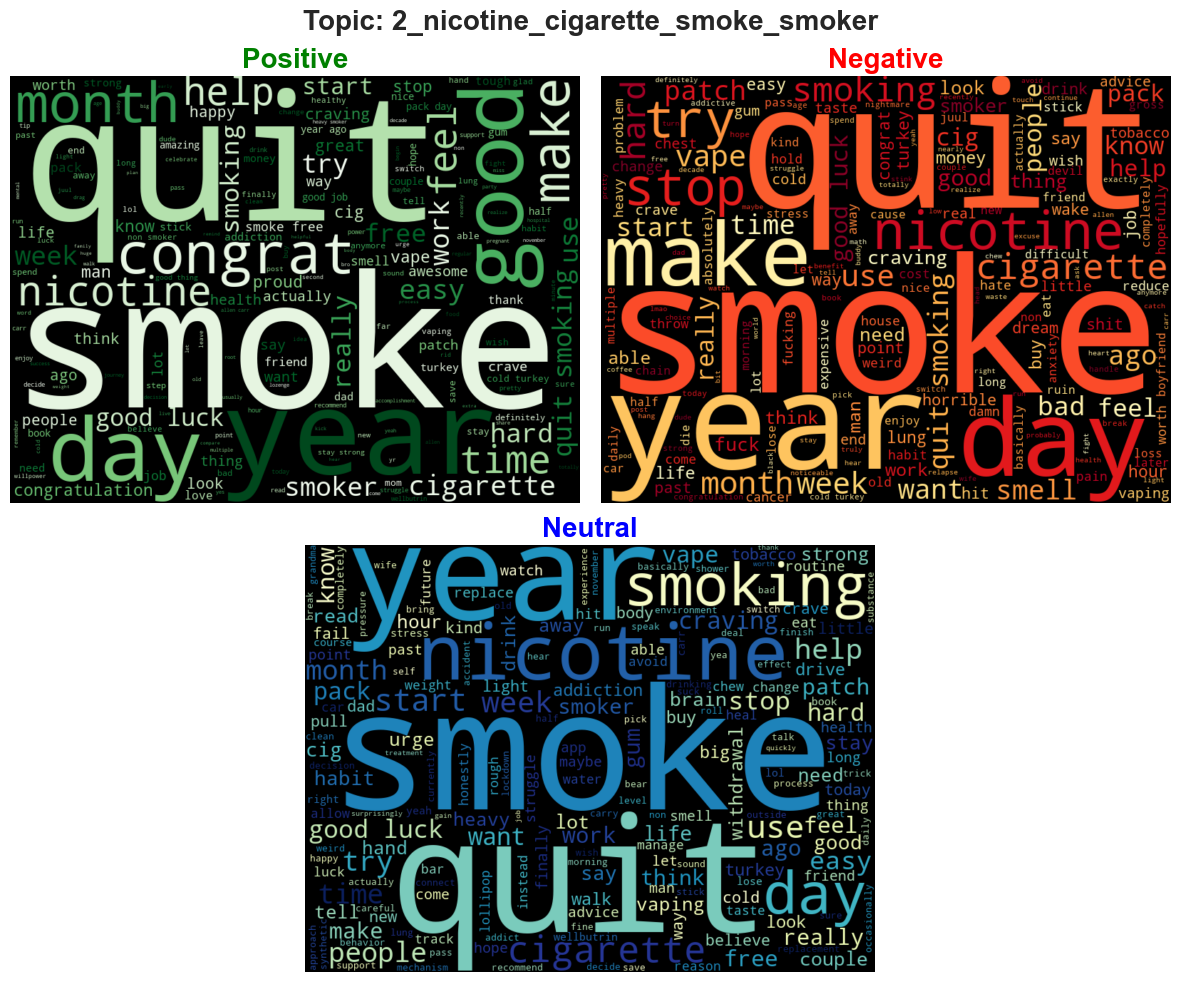

In [98]:
create_kw_wordcloud_by_sentiment(topic_num=2)